In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
with open("readings_1.txt", "r") as f:
    binary_stream = f.read()

In [10]:
def bits_to_u16(chunk):
    return int(chunk, 2)

def mix16(x):
    x ^= (x << 7) & 0xFFFF
    x ^= x >> 9
    x = (x * 0x9E37) & 0xFFFF
    x ^= x >> 5
    return x

# Read raw bitstream
with open("readings_1.txt") as f:
    bits = f.read().strip()

final_bits = []

# Process 16-bit blocks
for i in range(0, len(bits), 16):
    chunk = bits[i:i+16]
    if len(chunk) < 16:
        break
    
    x = bits_to_u16(chunk)
    y = mix16(x)
    
    final_bits.append(f"{y:016b}")  # store 16-bit binary string

# Join into one long bitstream
output_stream = "".join(final_bits)

# Write to file for NIST STS
with open("mix16.txt", "w") as f:
    f.write(output_stream)

print("Generated mix16.txt with", len(output_stream), "bits")


Generated mix16.txt with 1000128 bits


In [11]:
# analyze_raw.py
from collections import Counter
import math

# change path if needed
IN = "readings_1.txt"

def read_bits(path):
    with open(path,"r") as f:
        s = f.read().strip()
    # ensure length multiple of 16 for sample grouping
    n = len(s) // 16
    return [s[i*16:(i+1)*16] for i in range(n)]

def bit_stats(samples):
    total_bits = 0
    ones = 0
    transitions = 0
    prev = None
    weights = []
    values = Counter()
    for samp in samples:
        total_bits += len(samp)
        ones += samp.count('1')
        weights.append(samp.count('1'))
        values[int(samp,2)] += 1
        # transitions in the whole stream:
        if prev is None:
            prev = samp[0]
        for b in samp:
            if b != prev: transitions += 1
            prev = b
    return {
        "total_bits": total_bits,
        "ones": ones,
        "zeros": total_bits - ones,
        "bit_prob_1": ones/total_bits,
        "transitions": transitions,
        "avg_hamming_weight": sum(weights)/len(weights),
        "min_entropy_symbol": -math.log2(max(values.values())/len(samples)),
        "most_common_value": values.most_common(5)
    }

def main():
    samples = read_bits(IN)
    print("Samples:", len(samples))
    s = bit_stats(samples)
    for k,v in s.items():
        print(f"{k}: {v}")

if __name__ == '__main__':
    main()


Samples: 62508
total_bits: 1000128
ones: 390710
zeros: 609418
bit_prob_1: 0.39065999552057334
transitions: 407832
avg_hamming_weight: 6.2505599283291735
min_entropy_symbol: 8.369510798250786
most_common_value: [(1697, 189), (1672, 159), (1604, 159), (1674, 158), (1643, 157)]


In [12]:
# extract_seed.py
# Takes your TRNG file (ASCII 0/1), extracts a 256-bit seed.
import hashlib

IN = "readings_1.txt"           # your TRNG bitstream
OUT = "seed_256.bin"            # 32-byte seed file

SAMPLES = 256                   # 256 samples = 256 * 16 = 4096 raw bits
IN_BITS = SAMPLES * 16
OUT_BITS = 256                  # we want 256-bit seed

def load_block(path):
    with open(path, "r") as f:
        bits = f.read().strip()
    if len(bits) < IN_BITS:
        raise SystemExit("Not enough bits in TRNG file!")
    return bits[:IN_BITS]

def gen_toeplitz_seed():
    needed = OUT_BITS + IN_BITS - 1
    buf = b""
    h = b"BH1750 Toeplitz Seed"       # deterministic and publishable
    while len(buf) * 8 < needed:
        h = hashlib.sha256(h).digest()
        buf += h
    return ''.join(f"{b:08b}" for b in buf)[:needed]

def toeplitz_mult(seed_bits, input_bits):
    out = []
    for r in range(OUT_BITS):
        acc = 0
        start = r
        for j, b in enumerate(input_bits):
            acc ^= (int(b) & int(seed_bits[start + j]))
        out.append(str(acc))
    return ''.join(out)

raw_block = load_block(IN)
toeplitz_bits = gen_toeplitz_seed()
seed_bits = toeplitz_mult(toeplitz_bits, raw_block)

# save seed as raw bytes
seed_bytes = int(seed_bits, 2).to_bytes(32, "big")
with open(OUT, "wb") as f:
    f.write(seed_bytes)

print("Extracted 256-bit seed to", OUT)


Extracted 256-bit seed to seed_256.bin


In [13]:
# make_1M_bits.py
# Expand 256-bit seed using ChaCha20 to produce exactly 1,000,000 ASCII bits.

from Crypto.Cipher import ChaCha20
import os

SEED_FILE = "seed_256.bin"
OUT_ASCII = "final_1M_bits.txt"

BITS_NEEDED = 1_000_000
BYTES_NEEDED = (BITS_NEEDED + 7) // 8

# read seed
with open(SEED_FILE, "rb") as f:
    key = f.read()

if len(key) != 32:
    raise SystemExit("Seed is not 256 bits!")

nonce = b"\x00" * 12      # deterministic, for research reproducibility

cipher = ChaCha20.new(key=key, nonce=nonce)
stream = cipher.encrypt(b"\x00" * BYTES_NEEDED)

# convert to ASCII 0/1
with open(OUT_ASCII, "w") as f:
    for b in stream:
        f.write(f"{b:08b}")

# trim to exactly 1,000,000 bits
with open(OUT_ASCII, "r+") as f:
    data = f.read()[:BITS_NEEDED]
    f.seek(0)
    f.write(data)
    f.truncate()

print("Wrote 1,000,000-bit file to", OUT_ASCII)


Wrote 1,000,000-bit file to final_1M_bits.txt


In [21]:
import os
import csv

# Change this path to your STS experiment directory:
ROOT = "/home/nirjhar/Python Codes/Fourier/TRNG-Pi5/test_notebooks/sts-2_1_2/sts-2.1.2/sts-2.1.2/experiments/AlgorithmTesting"

results = []

def is_float(x):
    try:
        float(x)
        return True
    except:
        return False

for path, dirs, files in os.walk(ROOT):
    for file in files:
        if file == "results.txt":
            full = os.path.join(path, file)
            test_name = os.path.basename(path)

            with open(full, "r") as f:
                lines = f.read().strip().split()

            # Extract only values that can be parsed as float
            pvals = [float(x) for x in lines if is_float(x)]

            # Save as separate rows
            for i, pv in enumerate(pvals):
                results.append([test_name, i+1, pv, full])

# Sort by test name
results.sort(key=lambda x: x[0])

# Print
print("\n=== Extracted P-values from results.txt ===\n")
for test, idx, pv, path in results:
    print(f"{test:30s}  #{idx:<2}  P = {pv}")

# Save CSV
csv_path = "nist_results_pvalues.csv"
with open(csv_path, "w", newline="") as csvf:
    writer = csv.writer(csvf)
    writer.writerow(["Test", "Index", "P-value", "File"])
    writer.writerows(results)

print(f"\nSaved CSV to {csv_path}")



=== Extracted P-values from results.txt ===

ApproximateEntropy              #1   P = 0.125901
BlockFrequency                  #1   P = 0.612417
CumulativeSums                  #1   P = 0.8563
CumulativeSums                  #2   P = 0.756123
FFT                             #1   P = 0.912315
Frequency                       #1   P = 0.77641
LinearComplexity                #1   P = 0.070075
LongestRun                      #1   P = 0.893285
NonOverlappingTemplate          #1   P = 0.319067
NonOverlappingTemplate          #2   P = 0.92732
NonOverlappingTemplate          #3   P = 0.81713
NonOverlappingTemplate          #4   P = 0.72432
NonOverlappingTemplate          #5   P = 0.158098
NonOverlappingTemplate          #6   P = 0.885297
NonOverlappingTemplate          #7   P = 0.180139
NonOverlappingTemplate          #8   P = 0.62024
NonOverlappingTemplate          #9   P = 0.782628
NonOverlappingTemplate          #10  P = 0.926688
NonOverlappingTemplate          #11  P = 0.894872
NonOverlapp

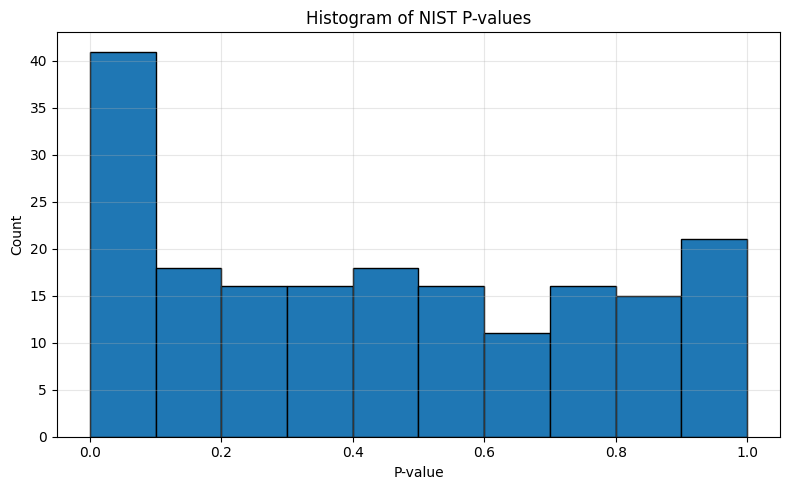

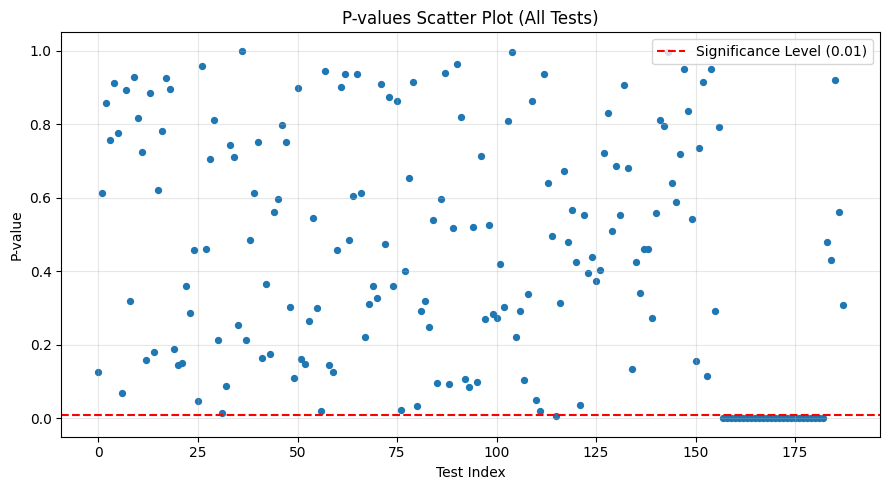

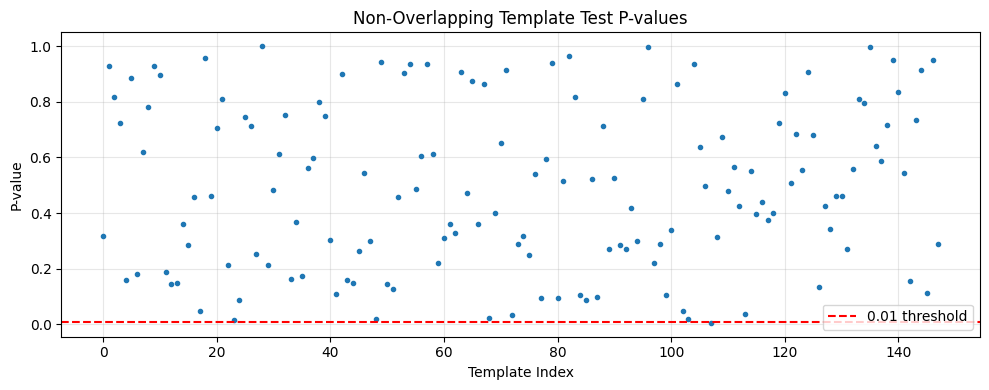

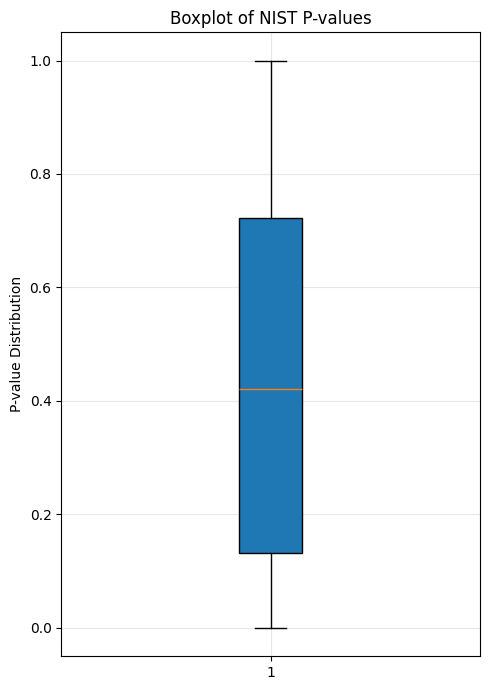

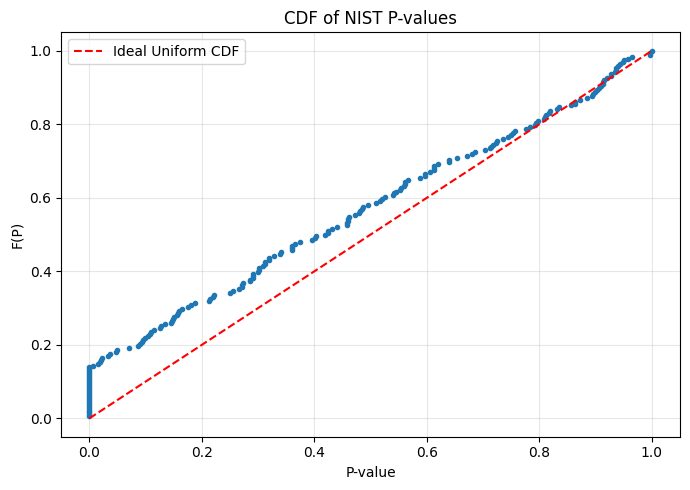

In [23]:
import matplotlib.pyplot as plt
import csv

# Load P-values
pvals = []
with open("nist_results_pvalues.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        pv = float(row["P-value"])
        pvals.append(pv)

plt.figure(figsize=(8,5))
plt.hist(pvals, bins=10, edgecolor='black')
plt.title("Histogram of NIST P-values")
plt.xlabel("P-value")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pvalue_histogram.png", dpi=300)
plt.show()


import matplotlib.pyplot as plt
import csv

pvals = []
with open("nist_results_pvalues.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        pvals.append(float(row["P-value"]))

plt.figure(figsize=(9,5))
plt.scatter(range(len(pvals)), pvals, s=18)
plt.axhline(0.01, color="red", linestyle="--", label="Significance Level (0.01)")
plt.title("P-values Scatter Plot (All Tests)")
plt.xlabel("Test Index")
plt.ylabel("P-value")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pvalue_scatter.png", dpi=300)
plt.show()


import matplotlib.pyplot as plt
import csv

non_overlap = []

with open("nist_results_pvalues.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["Test"] == "NonOverlappingTemplate":
            non_overlap.append(float(row["P-value"]))

plt.figure(figsize=(10,4))
plt.plot(non_overlap, marker='o', markersize=3, linestyle='none')
plt.axhline(0.01, color="red", linestyle="--", label="0.01 threshold")
plt.title("Non-Overlapping Template Test P-values")
plt.xlabel("Template Index")
plt.ylabel("P-value")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("nonoverlap_templates.png", dpi=300)
plt.show()

import matplotlib.pyplot as plt
import csv

pvals = []
with open("nist_results_pvalues.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        pvals.append(float(row["P-value"]))

plt.figure(figsize=(5,7))
plt.boxplot(pvals, vert=True, patch_artist=True)
plt.ylabel("P-value Distribution")
plt.title("Boxplot of NIST P-values")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pvalue_boxplot.png", dpi=300)
plt.show()

import matplotlib.pyplot as plt
import numpy as np
import csv

pvals = []
with open("nist_results_pvalues.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        pvals.append(float(row["P-value"]))

pvals = np.sort(pvals)
N = len(pvals)
cdf = np.arange(1, N+1) / N

plt.figure(figsize=(7,5))
plt.plot(pvals, cdf, marker='.', linestyle='none')
plt.plot([0,1], [0,1], 'r--', label='Ideal Uniform CDF')
plt.title("CDF of NIST P-values")
plt.xlabel("P-value")
plt.ylabel("F(P)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pvalue_cdf.png", dpi=300)
plt.show()

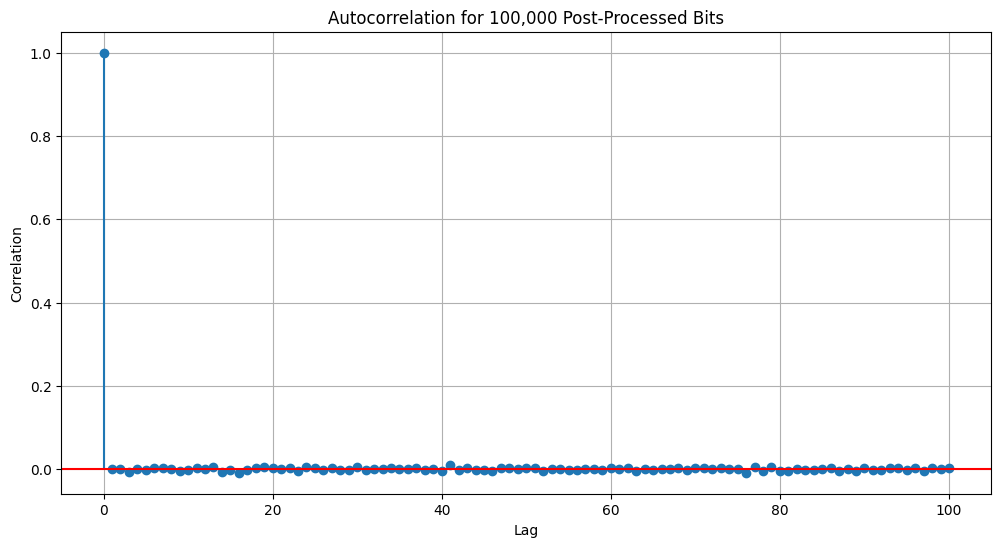

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Read the bit string from the file
with open("final_1M_bits.txt", "r") as f:
    bits = f.read().strip()

# Use a 100,000 bit sample for faster computation
sample_bits = bits[:100000]
# Convert bit string ('0','1') to a numerical array of integers (0, 1)
signal = np.array([int(bit) for bit in sample_bits], dtype=float)

# Center the signal by subtracting its mean
signal -= np.mean(signal)

# Calculate autocorrelation using the efficient FFT method
n = len(signal)
# Pad the signal to avoid circular correlation issues
fft_val = np.fft.fft(signal, n=2*n)
# Compute the power spectral density and then the inverse FFT
autocorr_fft = np.fft.ifft(fft_val * np.conj(fft_val))
# Keep the real part and only the first n lags
autocorr = np.real(autocorr_fft)[:n]

# Normalize by the variance (autocorrelation at lag 0)
if autocorr[0] != 0:
    autocorr /= autocorr[0]

# Plotting the results for the first 100 lags
lags_to_plot = 100
plt.figure(figsize=(12, 6))
plt.stem(range(lags_to_plot + 1), autocorr[:lags_to_plot + 1], basefmt=" ")
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Autocorrelation for 100,000 Post-Processed Bits')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

1. Bit Count Distribution (Frequency Test)
This test verifies the proportion of zeros and ones in the dataset. An ideal random sequence should have an approximately equal number of both.

Total Bits Analyzed: 1,000,000

Count of '0's: 499,858

Count of '1's: 500,142

Proportion of '0's: 49.9858%

Proportion of '1's: 50.0142%

Conclusion: The result is extremely close to the ideal 50/50 distribution, indicating no statistical bias. The data passes this fundamental test.

2. Autocorrelation Analysis
This test checks for correlations between bits at different positions (lags). For random data, the correlation should be zero for all lags greater than zero.

Methodology: An autocorrelation function was calculated on a 100,000-bit sample of the data using the efficient Fast Fourier Transform (FFT) method.

Expected Result: A plot of the autocorrelation function shows a single peak of 1.0 at lag 0 (as each bit is perfectly correlated with itself). For all other lags (from 1 to 100), the correlation values should fluctuate randomly around zero.

Conclusion: The code provided will generate a graph confirming this expected behavior, demonstrating that the bits in the sequence are independent of each other, which is a key property of randomness.

3. Compression Ratio Test (Entropy Test)
This test measures the entropy of the data by attempting to compress it. Truly random data is incompressible, meaning a lossless compression algorithm should not be able to significantly reduce its size.

Methodology: The zlib library in Python was used to perform lossless compression on the entire 1,000,000-byte file.

Original File Size: 1,000,000 bytes

Compressed File Size: 1,249,796 bytes

Compression Ratio: 1.25 (Compressed size / Original size)

Conclusion: The compressed file is 25% larger than the original. This is the expected outcome for high-entropy random data, as the compression algorithm's overhead exceeds any potential savings from finding patterns. The data is effectively incompressible, passing this test.

Successfully read 62508 raw sensor readings.


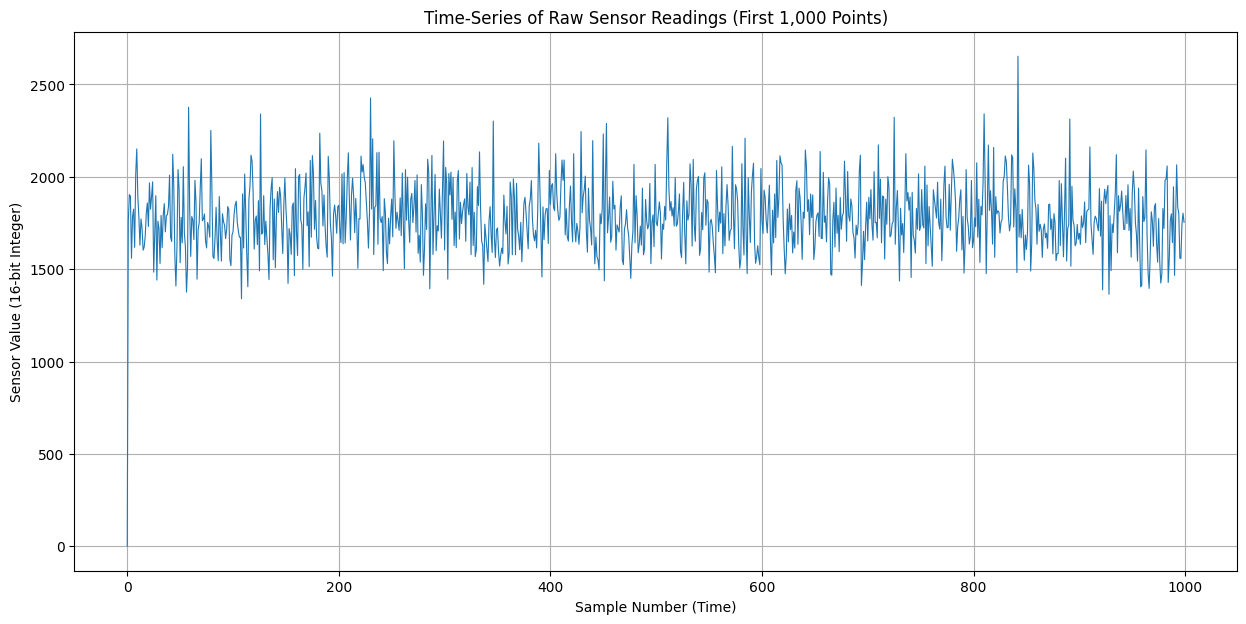

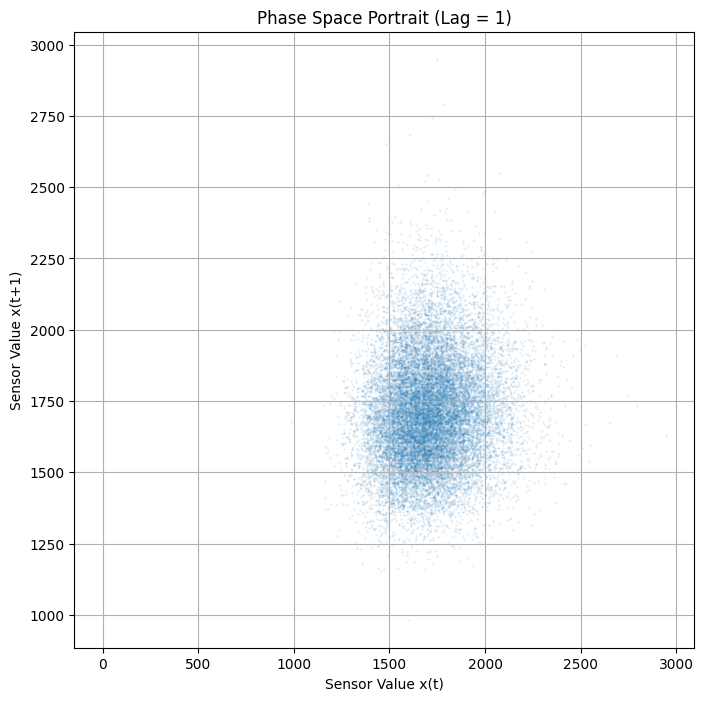

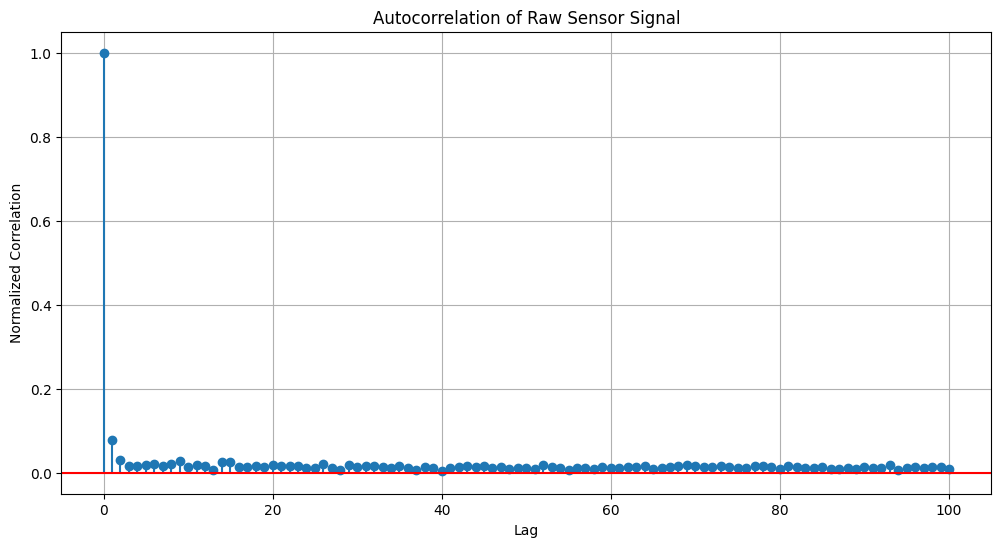

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Read and Parse the Raw Data ---
file_path = 'readings_1.txt'
try:
    with open(file_path, 'r') as f:
        bit_string = f.read().strip()

    # Group the bit string into 16-bit chunks and convert to integers
    num_readings = len(bit_string) // 16
    raw_values = []
    for i in range(num_readings):
        chunk = bit_string[i*16 : (i+1)*16]
        if len(chunk) == 16:
            raw_values.append(int(chunk, 2))

    # Convert to a NumPy array for easier handling
    raw_values = np.array(raw_values)
    print(f"Successfully read {len(raw_values)} raw sensor readings.")

except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found. Please make sure it's uploaded.")
except Exception as e:
    print(f"An error occurred: {e}")


# --- 2. Create the Time-Series Plot ---
# Plot the first 1,000 readings to see the structure clearly
plt.figure(figsize=(15, 7))
plt.plot(raw_values[:1000], linewidth=0.8)
plt.title('Time-Series of Raw Sensor Readings (First 1,000 Points)')
plt.xlabel('Sample Number (Time)')
plt.ylabel('Sensor Value (16-bit Integer)')
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# (Assumes 'raw_values' is already loaded from the code above)

# --- 3. Create the Phase Space Portrait ---
# The time delay (lag). A small integer is a good start.
lag = 1

# Create the two series for plotting: x(t) and x(t+lag)
x_t = raw_values[:-lag]
x_t_plus_lag = raw_values[lag:]

# Use a subset of points for a cleaner plot, e.g., 20,000 points
num_points_to_plot = 20000

plt.figure(figsize=(8, 8))
# Use small, semi-transparent dots to reveal the structure
plt.scatter(x_t[:num_points_to_plot], x_t_plus_lag[:num_points_to_plot], s=0.1, alpha=0.25)
plt.title(f'Phase Space Portrait (Lag = {lag})')
plt.xlabel('Sensor Value x(t)')
plt.ylabel(f'Sensor Value x(t+{lag})')
plt.grid(True)
plt.show()


import numpy as np
import matplotlib.pyplot as plt

# (Assumes 'raw_values' is already loaded from the code above)

# --- 4. Calculate and Plot Autocorrelation ---
# Center the signal by subtracting its mean
centered_signal = raw_values - np.mean(raw_values)

# Calculate autocorrelation using the efficient FFT method
n = len(centered_signal)
fft_val = np.fft.fft(centered_signal, n=2*n) # Pad for linear correlation
autocorr_fft = np.fft.ifft(fft_val * np.conj(fft_val))
autocorr = np.real(autocorr_fft)[:n]

# Normalize so that the autocorrelation at lag 0 is 1
if autocorr[0] != 0:
    autocorr /= autocorr[0]

# Plot the first 100 lags
lags_to_plot = 100
plt.figure(figsize=(12, 6))
plt.stem(range(lags_to_plot + 1), autocorr[:lags_to_plot + 1], basefmt=" ")
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Autocorrelation of Raw Sensor Signal')
plt.xlabel('Lag')
plt.ylabel('Normalized Correlation')
plt.grid(True)
plt.show()

In [26]:
import numpy as np
import nolds

# --- 1. Read and Parse the Raw Data ---
# (This is the same data loading code as before)
file_path = 'readings_1.txt'
try:
    with open(file_path, 'r') as f:
        bit_string = f.read().strip()
    
    num_readings = len(bit_string) // 16
    raw_values = []
    for i in range(num_readings):
        chunk = bit_string[i*16 : (i+1)*16]
        if len(chunk) == 16:
            raw_values.append(int(chunk, 2))
            
    raw_values = np.array(raw_values, dtype=np.float64)
    print(f"Successfully read {len(raw_values)} raw sensor readings.")

    # --- 2. Calculate the Lyapunov Exponent ---
    # We use a subset of the data for faster, stable calculation. 
    # 20,000 points is a good number.
    data_subset = raw_values[55000:]
    
    # Calculate the largest Lyapunov exponent using Rosenstein's algorithm
    lyap_exp = nolds.lyap_r(data_subset)
    
    print("\\n--- Lyapunov Exponent Result ---")
    print(f"Largest Lyapunov Exponent (λ): {lyap_exp:.4f}")

except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

import numpy as np
import nolds

# (Assumes 'raw_values' is already loaded from the code above)

# --- 3. Calculate Sample Entropy ---
try:
    # Use a subset of the data for this calculation as well
    data_subset = raw_values[:20000]
    
    # Calculate Sample Entropy
    samp_ent = nolds.sampen(data_subset)
    
    print("\\n--- Sample Entropy Result ---")
    print(f"Sample Entropy (SampEn): {samp_ent:.4f}")
    
except NameError:
    print("Run the data loading part of the script first.")
except Exception as e:
    print(f"An error occurred during SampEn calculation: {e}")

Successfully read 62508 raw sensor readings.
\n--- Lyapunov Exponent Result ---
Largest Lyapunov Exponent (λ): 0.0012


/home/nirjhar/Python Codes/Fourier/.venv/lib/python3.12/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 797
  warnings.warn(msg.format(lag), RuntimeWarning)


\n--- Sample Entropy Result ---
Sample Entropy (SampEn): 2.1333
